## SEG Conference (IMAGE21) Text Analytics Report
### Yang Zhang
### Oct 2021

## Table of Content:

 1. [Data Processing](#process)
 2. [Stats using Counts and Document term matrix](#count)
 3. [Stats using TFIDF](#tfidf)
     1. [Method1](#method1)
     2. [Method2](#method2)
 4. [Bigrams and Trigrams](#bigram)
 5. [Topic Model](#topic)
 6. [Docoment Similarity](#doc)

In [161]:
import os, pickle

import nltk, string, copy, re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
#from num2words import num2words
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np, pandas as pd
import math

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from wordcloud import WordCloud
from corpus_toolkit import corpus_tools as ct
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yzad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## Data Processing  <a name='process'></a>

In [71]:
# Data Processing Functions

def convert_lower_case(data):
    return np.char.lower(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_pagebreak(data):
    symbols = "\r\n"
    data = np.char.replace(data, symbols, ' ')
    #for i in range(len(symbols)):
    #    data = np.char.replace(data, symbols[i], ' ')
    #    data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

def preprocess(data):
    data = convert_lower_case(data)
    data = remove_pagebreak(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_pagebreak(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

In [79]:
# Reading in files

f=open(r'C:/Users/yzad/OneDrive - Chevron/Pdrive/2021_SEG/IMAGE21_OfficalProgram_FINALtest.pdf.txt', "rb")
file_name_and_text = f.read()
file_name_and_text

b'Tuesday, 28 September\r\n\r\n8:00 a.m.\xe2\x80\x939:40 a.m.\r\n\r\n10:20 a.m.\xe2\x80\x9312:00 p.m.\r\n\r\n1:20 p.m.\xe2\x80\x933:00 p.m.\r\n\r\n3:40 p.m.\xe2\x80\x935:20 p.m.\r\n\r\nDAS 2: Advances in Processing and Acquisition 1\r\n\r\nMLDA 3: Interpretation\r\n\r\nFWI 3: Elastic Full-Waveform Inversion\r\n\r\nRC 1: Integrated Attribute Case Studies 3\r\n\r\nIn-Person Sessions\r\n\r\nINT 1: Machine Learning in Assisting Seismic Interpretation \r\n\r\nSPET 2: New Developments, Novel Application, and Case Studies 1\r\n\r\nSPMI 2: Least-Squares Migration and Elastic Imaging 1\r\n\r\nSPMNR 3: Machine-Learning Applications for Noise and Multiple Attenuation 1\r\n\r\nSUS 1: Applying Geophysics for Sustainable Development\r\n\r\nPS 1: Microseismicity, Distributed Acoustic Sensing, and Ambient Noise Analyses  1\r\n\r\nAVOSI 2: Algorithms, Methodology, and Case Studies 2\r\n\r\nGM 1: Interpretation 1\r\n\r\nTL 1: Advances and Case Studies\r\n\r\nTheme 5: Basin and Play Scale \r\n\r\nCharact

In [117]:
#Data Processing
import pandas as pd

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

file_new = file_name_and_text.decode('utf-8')
file_new = convert_lower_case(file_new)
file_new = convert_numbers(file_new)
file_new = remove_punctuation(file_new)
file_new = remove_stop_words(file_new)
file_new = convert_numbers(file_new)
file_new

array(' tuesday 28 september 00 –9 40 10 20 –12 00 20 –3 00 40 –5 20 das advances processing acquisition mlda interpretation fwi elastic full waveform inversion rc integrated attribute case studies person sessions int machine learning assisting seismic interpretation spet new developments novel application case studies spmi least squares migration elastic imaging spmnr machine learning applications noise multiple attenuation sus applying geophysics sustainable development ps microseismicity distributed acoustic sensing ambient noise analyses avosi algorithms methodology case studies gm interpretation tl advances case studies theme basin play scale characterization unconventional reservoirs theme pore scale techniques characterizing mudstone reservoirs theme advances geophysics unconventional reservoirs theme application geochemistry reservoir characterization reserves recovery factor theme successes challenges data integration multi disciplinary theme machine learning insight opportuni

In [105]:
#Tokenizer

df_full = pd.DataFrame([file_new])
tokenizer = RegexpTokenizer(r'\w+')
df_full_lower = df_full[0].apply(lambda x: tokenizer.tokenize(x.lower()))

In [107]:
#Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['00', 'theme', '30','20','session','september','12','regency','hyatt','program','chair','panel','room','time','co','26','21','10','sepm','p1','p2','p3','p4','13','1','2','3','5','8','p','4']
stopwords.extend(newStopWords)

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords]
    return words

df_full_lower = df_full_lower.apply(lambda x : remove_stopwords(x))

## Using Count/Document term matrix  <a name='count'></a>

In [144]:
#lemmatization
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

In [145]:
df_full_lem = df_full_lower.apply(lambda x: word_lemmatizer(x))
df_full_lem.head()

0    tuesday 28 9 40 40 da advance processing acqui...
Name: 0, dtype: object

In [146]:
#Create DTM
cv = CountVectorizer(ngram_range = (1,1))
dtm = cv.fit_transform(df_full_lem)

words = np.array(cv.get_feature_names())
print(pd.DataFrame.from_records(dtm[:5,:5].A, columns=words[:5]))
dtm_df = pd.DataFrame.from_records(dtm.A, columns=words)

   05  100  101  11  125
0   2    1    1   6    1


In [147]:
q1 = dtm[0]
freqs_q1=q1.sum(axis=0).A.flatten()
index=np.argsort(freqs_q1)[-10:] 
print(list(zip(words[index], freqs_q1[index]))) 

[('development', 17), ('online', 17), ('method', 18), ('poster', 18), ('new', 18), ('learning', 19), ('case', 22), ('system', 27), ('application', 29), ('reservoir', 35)]


In [148]:
#Look at top 50 most frequent words
freqs=dtm.sum(axis=0).A.flatten() 
index=np.argsort(freqs)[-50:] 
print(list(zip(words[index], freqs[index]))) 

[('workshop', 7), ('depositional', 7), ('siliciclastic', 7), ('part', 8), ('int', 8), ('exploration', 8), ('session', 8), ('algorithm', 8), ('stratigraphic', 8), ('carbon', 8), ('challenge', 8), ('aapg', 8), ('sedimentary', 9), ('noise', 9), ('fwi', 9), ('imageevent', 9), ('time', 9), ('org', 9), ('geologic', 9), ('date', 10), ('modeling', 10), ('data', 10), ('imaging', 11), ('geochemistry', 11), ('advance', 11), ('history', 11), ('mlda', 12), ('inversion', 12), ('interpretation', 12), ('processing', 12), ('research', 13), ('carbonate', 14), ('geophysics', 15), ('student', 15), ('unconventional', 15), ('analysis', 15), ('study', 15), ('seismic', 16), ('characterization', 16), ('machine', 17), ('development', 17), ('online', 17), ('method', 18), ('poster', 18), ('new', 18), ('learning', 19), ('case', 22), ('system', 27), ('application', 29), ('reservoir', 35)]


### Visualization and Wordcloud

<AxesSubplot:ylabel='Word'>

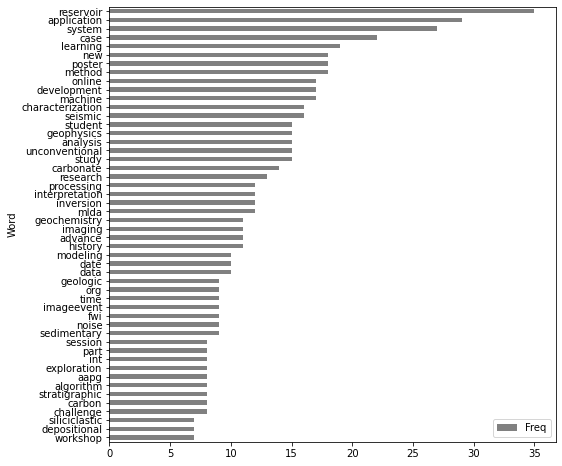

In [150]:
WordFreq = pd.DataFrame.from_records(list(zip(words[index], freqs[index]))) 
WordFreq.columns = ['Word', 'Freq']

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
WordFreq.sort_values(by='Freq').plot.barh(x='Word',
                      y='Freq',
                      ax=ax,
                      color="gray")

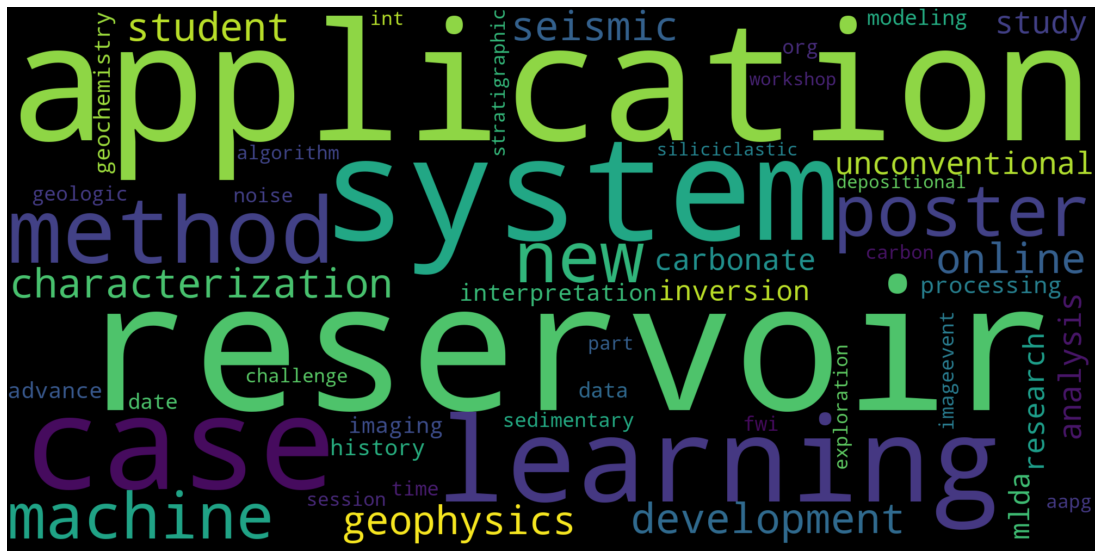

In [151]:
from wordcloud import WordCloud

data = dict(zip(WordFreq['Word'].tolist(), WordFreq['Freq'].tolist()))
wordcloud = WordCloud(width=2000, height=1000).generate_from_frequencies(data)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


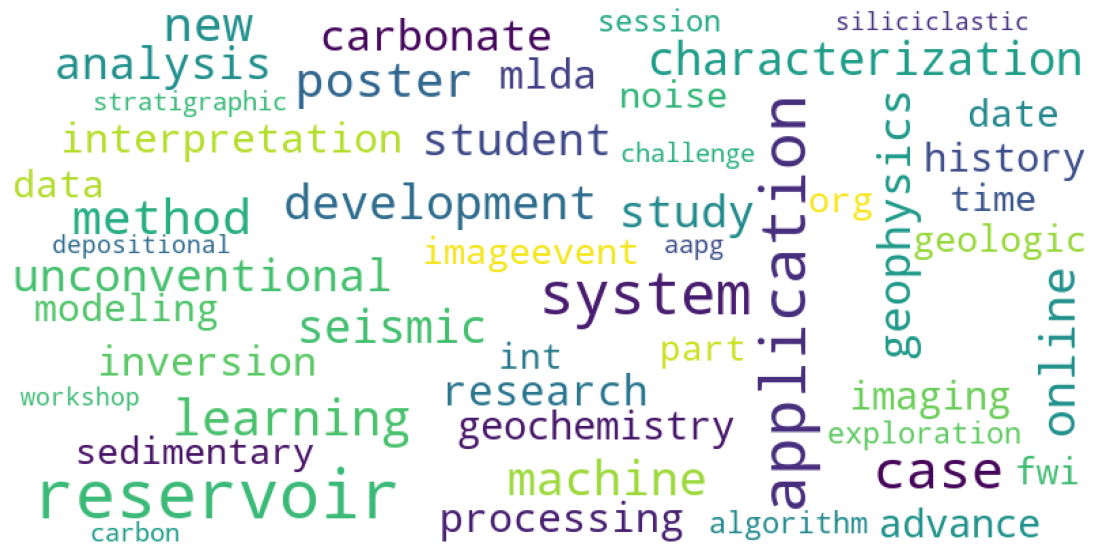

In [152]:
wordcloud = WordCloud(width=800, height=400,background_color='white',max_font_size = 50).generate_from_frequencies(data)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## TFIDF <a name='tfidf'></a>


### Using TFIDF Method1 <a name='method1'></a>

In [164]:
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
tfidf_wm = tfidfvectorizer.fit_transform(df_full_lem)

In [166]:
words_tfidf = np.array(tfidfvectorizer.get_feature_names())
print(pd.DataFrame.from_records(tfidf_wm[:5,:5].A, columns=words_tfidf[:5]))
tfidf_wm_df = pd.DataFrame.from_records(tfidf_wm.A, columns=words_tfidf)

        05       100       101        11       125
0  0.01771  0.008855  0.008855  0.053129  0.008855


In [168]:
#Look at top 50 most frequent words
freqs_tfidf=tfidf_wm.sum(axis=0).A.flatten() 
index=np.argsort(freqs_tfidf)[-50:] 
print(list(zip(words_tfidf[index], freqs_tfidf[index]))) 

[('tectonics', 0.06198331987655927), ('resource', 0.06198331987655927), ('technique', 0.06198331987655927), ('person', 0.06198331987655927), ('play', 0.06198331987655927), ('int', 0.07083807985892489), ('exploration', 0.07083807985892489), ('challenge', 0.07083807985892489), ('algorithm', 0.07083807985892489), ('aapg', 0.07083807985892489), ('carbon', 0.07083807985892489), ('session', 0.07083807985892489), ('stratigraphic', 0.07083807985892489), ('fwi', 0.0796928398412905), ('imageevent', 0.0796928398412905), ('time', 0.0796928398412905), ('sedimentary', 0.0796928398412905), ('noise', 0.0796928398412905), ('org', 0.0796928398412905), ('geologic', 0.0796928398412905), ('data', 0.0885475998236561), ('modeling', 0.0885475998236561), ('date', 0.0885475998236561), ('imaging', 0.09740235980602172), ('geochemistry', 0.09740235980602172), ('advance', 0.09740235980602172), ('history', 0.09740235980602172), ('inversion', 0.10625711978838732), ('interpretation', 0.10625711978838732), ('processing

<AxesSubplot:ylabel='Word'>

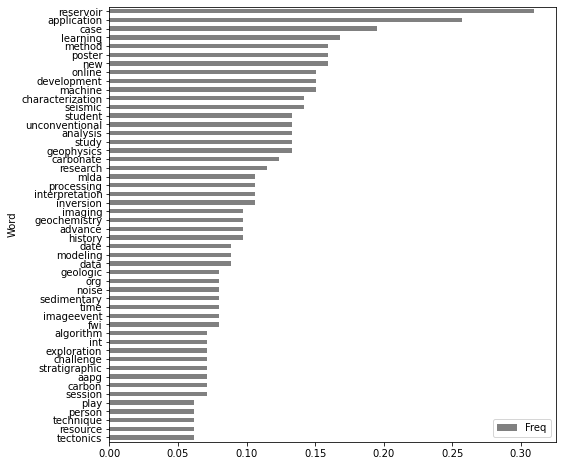

In [172]:
WordFreq = pd.DataFrame.from_records(list(zip(words_tfidf[index], freqs_tfidf[index]))) 
WordFreq.columns = ['Word', 'Freq']

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
WordFreq.sort_values(by='Freq').plot.barh(x='Word',
                      y='Freq',
                      ax=ax,
                      color="gray")

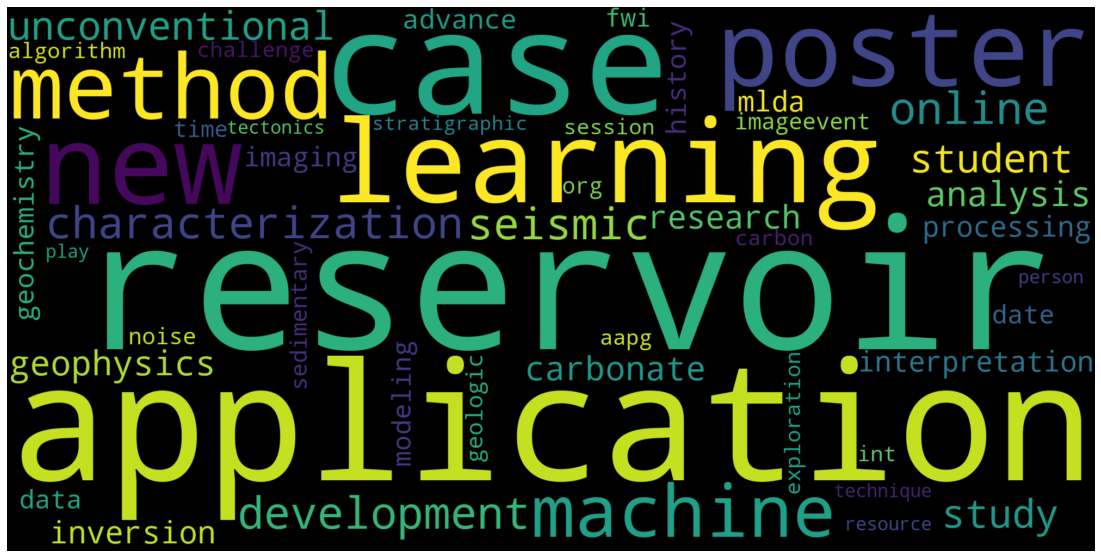

In [173]:
from wordcloud import WordCloud

data = dict(zip(WordFreq['Word'].tolist(), WordFreq['Freq'].tolist()))
wordcloud = WordCloud(width=2000, height=1000).generate_from_frequencies(data)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

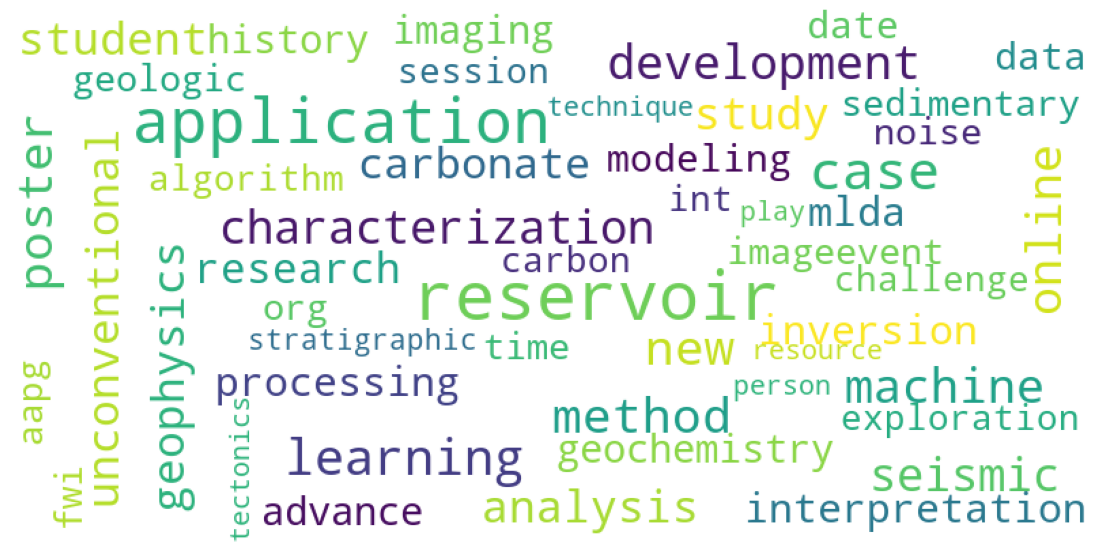

In [174]:
wordcloud = WordCloud(width=800, height=400,background_color='white',max_font_size = 50).generate_from_frequencies(data)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Using TFIDF Method 2 <a name='method2'></a>

In [108]:
# Total Vocabulary

DF = {token:0 for doc in df_full_lower for token in doc}
vocab = list(DF.keys())
for doc in df_full_lower:
    for token in DF.keys():
        if token in doc:
            DF[token] +=1
            
vocab_size = len(vocab)
vocab_size

559

In [110]:
# Calculate TFIDF

N = len(df_full_lower) # Total number of documents
tfidf = {}

for i, doc in enumerate(df_full_lower):
    counter = Counter(doc)
    words_count = len(doc)
    
    for token in set(doc):
        tf = counter[token] / words_count
        idf = np.log(N / DF[token] + 1)
        #tfidf[i, token] = tf * idf
        tfidf[token] = tf * idf
        
tfidf

{'sectors': 0.0004053492283976288,
 'honoring': 0.0008106984567952576,
 'nonmarine': 0.0004053492283976288,
 'heading': 0.0004053492283976288,
 'mega': 0.0004053492283976288,
 'learned': 0.0012160476851928864,
 'tl': 0.0016213969135905153,
 'williams': 0.0004053492283976288,
 'spet': 0.002432095370385773,
 'texas': 0.0004053492283976288,
 'int': 0.0032427938271810306,
 'geology': 0.0012160476851928864,
 'carbon': 0.0032427938271810306,
 '2021': 0.0012160476851928864,
 'university': 0.0008106984567952576,
 'edman': 0.0008106984567952576,
 'already': 0.0004053492283976288,
 'mechanical': 0.0004053492283976288,
 'save': 0.0004053492283976288,
 'geotechnics': 0.0004053492283976288,
 'velocity': 0.0004053492283976288,
 'professionals': 0.002026746141988144,
 'method': 0.0008106984567952576,
 'saad': 0.0008106984567952576,
 'array': 0.0004053492283976288,
 'illinois': 0.0004053492283976288,
 '9': 0.0008106984567952576,
 'continuity': 0.0004053492283976288,
 'opportunity': 0.00162139691359051

In [119]:
# Sort Words by TFIDF value

sort_tfidf = dict(sorted(tfidf.items(), key=lambda item: item[1], reverse=True))

sort_tfidf

{'systems': 0.01053907993833835,
 'applications': 0.01013373070994072,
 'case': 0.008917683024747835,
 'learning': 0.007701635339554948,
 'reservoirs': 0.007701635339554948,
 'new': 0.0072962861111573185,
 'online': 0.00689093688275969,
 'machine': 0.00689093688275969,
 'seismic': 0.006485587654362061,
 'characterization': 0.006485587654362061,
 'reservoir': 0.006485587654362061,
 'methods': 0.006485587654362061,
 'studies': 0.006080238425964432,
 'geophysics': 0.006080238425964432,
 'posters': 0.006080238425964432,
 'unconventional': 0.006080238425964432,
 'research': 0.005269539969169175,
 'processing': 0.004864190740771546,
 'inversion': 0.004864190740771546,
 'mlda': 0.004864190740771546,
 'interpretation': 0.004864190740771546,
 'advances': 0.0044588415123739174,
 'imaging': 0.0044588415123739174,
 'geochemistry': 0.0044588415123739174,
 'carbonate': 0.0044588415123739174,
 'analysis': 0.0044588415123739174,
 'modeling': 0.004053492283976288,
 'data': 0.004053492283976288,
 'times

In [114]:
df_sort_tfidf = pd.DataFrame.from_dict(sort_tfidf, orient='index',columns=['tfidf'])

df_sort_tfidf['Word'] = df_sort_tfidf.index

df_sort_tfidf = df_sort_tfidf.reset_index(drop=True)

df_sort_tfidf

,tfidf,Word
0,0.010539,systems
1,0.010134,applications
2,0.008918,case
3,0.007702,learning
4,0.007702,reservoirs
...,...,...
554,0.000405,access
555,0.000405,styles
556,0.000405,maintain
557,0.000405,planetary


### Visualization and Wordcloud

<AxesSubplot:ylabel='Word'>

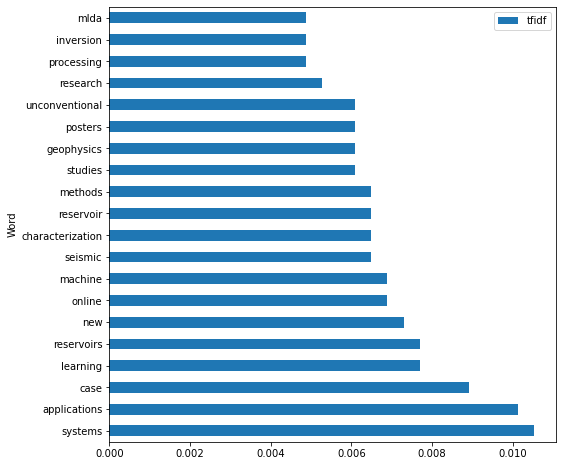

In [120]:
temp = df_sort_tfidf[0:20]
fig, ax = plt.subplots(figsize=(8, 8))
temp.plot.barh(x='Word',
                      y='tfidf',
                      ax=ax)

<AxesSubplot:ylabel='Word'>

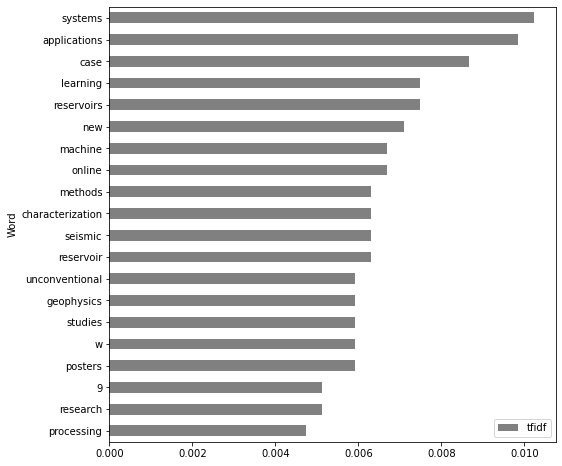

In [186]:
# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
temp.sort_values(by='tfidf').plot.barh(x='Word',
                      y='tfidf',
                      ax=ax,
                      color="gray")

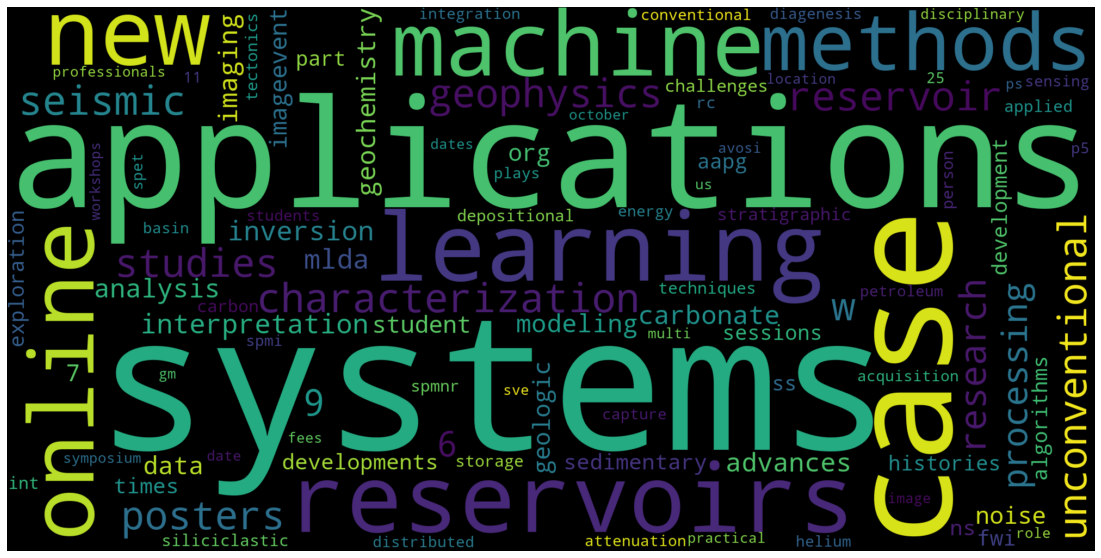

In [227]:
from wordcloud import WordCloud

temp = df_sort_tfidf[0:100]

data = dict(zip(temp['Word'].tolist(), temp['tfidf'].tolist()))
wordcloud = WordCloud(width=2000, height=1000).generate_from_frequencies(data)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

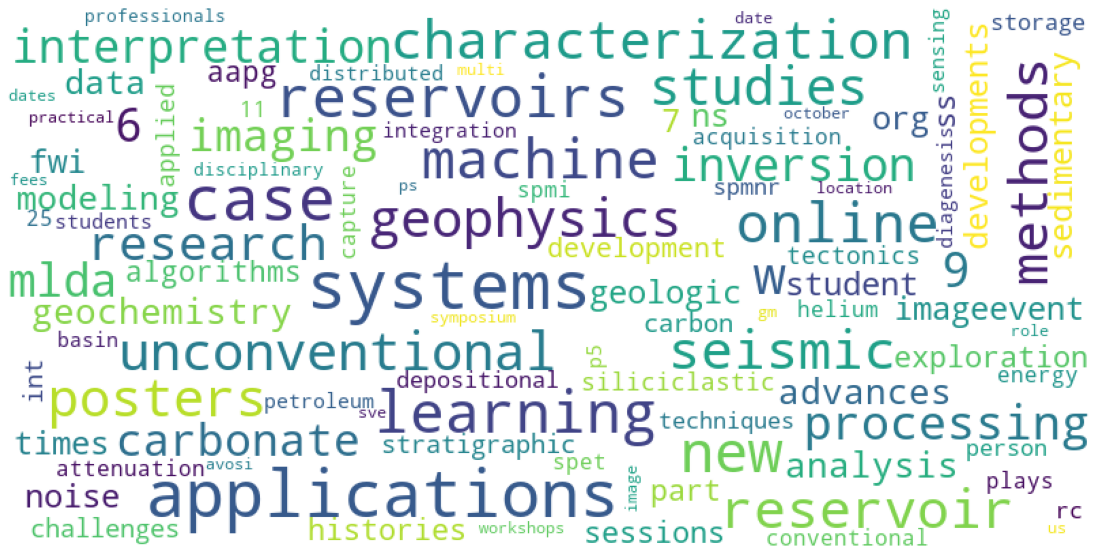

In [228]:
wordcloud = WordCloud(width=800, height=400,background_color='white',max_font_size = 50).generate_from_frequencies(data)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [17]:
#Matrix for TFIDF
D = np.zeros((N, vocab_size))

In [18]:
for k, v in tfidf.items():
    ind = vocab.index(k[1])
    D[k[0]][ind] = v
    
D

array([[0.00069245, 0.00092327, 0.00438555, 0.007617  , 0.00738618,
        0.007617  , 0.015234  , 0.00300064, 0.00092327, 0.00138491,
        0.00184655, 0.00369309, 0.00923273, 0.02308182, 0.01038682,
        0.00646291, 0.00092327, 0.02077364, 0.002539  , 0.01477237,
        0.00276982, 0.04339383, 0.00138491, 0.00276982, 0.00276982,
        0.00207736, 0.00069245, 0.00046164, 0.00046164, 0.00276982,
        0.00161573, 0.00069245, 0.00069245, 0.005078  , 0.00346227,
        0.00161573, 0.00184655, 0.00184655, 0.00392391, 0.00438555,
        0.00023082, 0.00369309, 0.00138491, 0.00415473, 0.00207736,
        0.00092327, 0.00092327, 0.00138491, 0.00046164, 0.00046164,
        0.00092327, 0.002539  , 0.00161573, 0.00577046, 0.00830946,
        0.00207736, 0.00069245, 0.00138491, 0.00046164, 0.00023082,
        0.00346227, 0.00092327, 0.00184655, 0.00115409, 0.00046164,
        0.00138491, 0.00069245, 0.00138491, 0.00046164, 0.00092327,
        0.00115409, 0.00184655, 0.00092327, 0.00

## Bigrams and Trigrams <a name='bigram'></a>

In [194]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()


In [196]:
import nltk
nltk.download('genesis')

[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\yzad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\genesis.zip.


True

In [155]:
import nltk
nltk.download('webtext')

from nltk.corpus import webtext
# use to find bigrams, which are pairs of words
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

words = [w.lower() for w in webtext.words(
    'C:/Users/yzad/OneDrive - Chevron/Pdrive/2021_SEG/IMAGE21_OfficalProgram_FINALtest.pdf.txt')]
words_clean = remove_punctuation(words)
biagram_collocation = BigramCollocationFinder.from_words(words_clean)
biagram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 80)

[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\yzad\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


[('â', '\x80\x93'),
 ('00', 'p'),
 (' ', 'm'),
 ('m', ' '),
 (' ', ' '),
 ('case', 'studies'),
 ('30', 'a'),
 ('p', ' '),
 ('machine', 'learning'),
 (' ', '00'),
 ('reservoir', 'characterization'),
 ('8', ' '),
 ('', 'and'),
 ('\x80\x93', '12'),
 ('carbonate', 'depositional'),
 ('case', 'histories'),
 (' ', 'â'),
 ('carbon', 'capture'),
 ('p1', ' '),
 ('advances', 'in'),
 ('depositional', 'systems'),
 ('5', ' '),
 ('unconventional', 'reservoirs'),
 ('p2', ' '),
 ('a', ' '),
 ('is', 'subject'),
 ('mountain', 'daylight'),
 ('\x80\x99', 's'),
 ('student', 'research'),
 ('research', 'symposium'),
 ('\x80\x93', '5'),
 ('date', 'information'),
 ('postconvention', 'workshops'),
 ('schedule', 'is'),
 ('siliciclastic', 'systems'),
 (' ', '30'),
 ('resource', 'plays'),
 ('', 'part'),
 ('3', ' '),
 ('daylight', 'time'),
 ('w', ' '),
 ('stratigraphic', 'sciences'),
 ('theme', '13'),
 ('listed', 'are'),
 ('times', 'listed'),
 ('visit', 'imageevent'),
 ('4', ' '),
 ('2', 'theme'),
 ('theme', '5'),
 

In [136]:
from nltk.corpus import stopwords
  
stopset = set(stopwords.words('english'))
filter_stops = lambda w: len(w) < 3 or w in stopset
  
biagram_collocation.apply_word_filter(filter_stops)
biagram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 30)

[('case', 'studies'),
 ('machine', 'learning'),
 ('reservoir', 'characterization'),
 ('carbonate', 'depositional'),
 ('case', 'histories'),
 ('carbon', 'capture'),
 ('depositional', 'systems'),
 ('unconventional', 'reservoirs'),
 ('mountain', 'daylight'),
 ('student', 'research'),
 ('research', 'symposium'),
 ('date', 'information'),
 ('postconvention', 'workshops'),
 ('siliciclastic', 'systems'),
 ('resource', 'plays'),
 ('daylight', 'time'),
 ('stratigraphic', 'sciences'),
 ('times', 'listed'),
 ('visit', 'imageevent'),
 ('integrated', 'attribute'),
 ('lessons', 'learned'),
 ('uncertainty', 'analysis'),
 ('sepm', 'research'),
 ('program', 'schedule'),
 ('shallow', 'marine'),
 ('noise', 'attenuation'),
 ('october', '2021'),
 ('data', 'integration'),
 ('acoustic', 'sensing'),
 ('distributed', 'acoustic')]

In [224]:
# Loading Libraries
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures
  
# Loading data - text file
words = [w.lower() for w in webtext.words(
    'C:/Users/yzad/OneDrive - Chevron/Pdrive/2021_SEG/IMAGE21_OfficalProgram_FINALtest.pdf.txt')]
  
trigram_collocation = TrigramCollocationFinder.from_words(words)
trigram_collocation.apply_word_filter(filter_stops)
trigram_collocation.apply_freq_filter(2)
  
trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 30)

[('attribute', 'case', 'studies'),
 ('multiattribute', 'case', 'studies'),
 ('carbonate', 'depositional', 'systems'),
 ('sepm', 'research', 'symposium'),
 ('reservoir', 'characterization', 'theme'),
 ('mountain', 'daylight', 'time'),
 ('student', 'research', 'posters'),
 ('carbon', 'capture', 'use'),
 ('aapg', 'student', 'research'),
 ('sepm', 'student', 'research'),
 ('unconventional', 'reservoirs', 'theme'),
 ('shallow', 'marine', 'sedimentary'),
 ('distributed', 'acoustic', 'sensing'),
 ('integrated', 'attribute', 'case'),
 ('marine', 'sedimentary', 'systems'),
 ('geothermal', 'knowledge', 'transferability'),
 ('ambient', 'noise', 'analyses'),
 ('person', 'posters', 'avosi'),
 ('modern', 'technologies', 'applied'),
 ('borehole', 'geophysical', 'methods'),
 ('borehole', 'seismic', 'measurements'),
 ('online', 'technical', 'program'),
 ('aapg', 'additional', 'student'),
 ('online', 'posters', 'spmi'),
 ('additional', 'student', 'posters'),
 ('gas', 'hydrates', 'theme')]

In [156]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
# Ngrams with 'creature' as a member
creature_filter = lambda *w: 'application' not in w

## Bigrams
finder = BigramCollocationFinder.from_words(
   words)
# only bigrams that appear 2+ times
finder.apply_freq_filter(2)
# only bigrams that shows no stopwords
finder.apply_word_filter(filter_stops)
# only bigrams that contain 'creature'
finder.apply_ngram_filter(creature_filter)
# return the 10 n-grams with the highest PMI
# print (finder.nbest(bigram_measures.likelihood_ratio, 10))
for i in finder.score_ngrams(bigram_measures.likelihood_ratio):
    print (i)

(('novel', 'application'), 23.217110695901376)


In [158]:
## Trigrams
trigram_measures = nltk.collocations.TrigramAssocMeasures()
# Ngrams with 'creature' as a member
creature_filter = lambda *w: 'carbon' not in w
finder = TrigramCollocationFinder.from_words(
   words)
# only trigrams that appear 3+ times
finder.apply_freq_filter(2)
# only trigrams that contain 'creature'
finder.apply_ngram_filter(creature_filter)
# only bigrams that shows no stopwords
finder.apply_word_filter(filter_stops)
# return the 10 n-grams with the highest PMI
# print (finder.nbest(trigram_measures.likelihood_ratio, 10))
for i in finder.score_ngrams(trigram_measures.likelihood_ratio):
    print (i)

(('carbon', 'capture', 'use'), 152.78640784539215)


Reference
- https://www.geeksforgeeks.org/nlp-word-collocations/
- https://towardsdatascience.com/collocations-in-nlp-using-nltk-library-2541002998db

## Topic Models <a name='topic'></a>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [22]:
# from io import StringIO

 

from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

 

import os
#if not os.path.exists(''):
#    os.makedirs('C:/Users/yzad/OneDrive - Chevron/Pdrive/2021_SEG/paper/txt')

 

#Read pdf and convert to txt
file_names = os.listdir(r'C:/Users/yzad/OneDrive - Chevron/Pdrive/2021_SEG/paper/')
file_name_and_text = {}
for file in file_names:
    print(file)
    output_string = StringIO()
    with open(r'C:/Users/yzad/OneDrive - Chevron/Pdrive/2021_SEG/paper/' + file,  'rb') as in_file:
        parser = PDFParser(in_file)
        doc = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        for page in PDFPage.create_pages(doc):
            interpreter.process_page(page)
    #f = open('txt/'+ file +'.txt', 'w', encoding='utf-8')
    f = open(file +'.txt', 'w', encoding='utf-8')
    f.write(output_string.getvalue())
    f.close()

segam2021-3580622.1.pdf
segam2021-3581244.1.pdf
segam2021-3582178.1.pdf
segam2021-3582611.1.pdf
segam2021-3582926.1.pdf
segam2021-3583101.1.pdf
segam2021-3584118.1.pdf
segam2021-3584963.1.pdf
segam2021-3588888.1.pdf
segam2021-3594315.1.pdf
segam2021-3594593.1.pdf
segam2021-3594792.1.pdf
segam2021-3594870.1.pdf


In [23]:
#Read in Text files from folder
file_names = os.listdir(r'C:/Users/yzad/OneDrive - Chevron/Pdrive/2021_SEG/paper/txt')
file_name_and_text = {}
file_names

['segam2021-3580622.1.pdf.txt',
 'segam2021-3581244.1.pdf.txt',
 'segam2021-3582178.1.pdf.txt',
 'segam2021-3582611.1.pdf.txt',
 'segam2021-3582926.1.pdf.txt',
 'segam2021-3583101.1.pdf.txt',
 'segam2021-3584118.1.pdf.txt',
 'segam2021-3584963.1.pdf.txt',
 'segam2021-3588888.1.pdf.txt',
 'segam2021-3594315.1.pdf.txt',
 'segam2021-3594593.1.pdf.txt',
 'segam2021-3594792.1.pdf.txt',
 'segam2021-3594870.1.pdf.txt']

In [196]:
#Read in Text files from folder
file_names = os.listdir(r'C:/Users/yzad/OneDrive - Chevron/Pdrive/2021_SEG/paper/txt/')
file_name_and_text = {}
for file in file_names:
    with open(r'C:/Users/yzad/OneDrive - Chevron/Pdrive/2021_SEG/paper/txt/' + file, "rb") as target_file:
         file_name_and_text[file] = target_file.read()
InAd_DF = (pd.DataFrame.from_dict(file_name_and_text, orient='index')
             .reset_index().rename(index = str, columns = {'index': 'file_name', 0: 'text'}))

In [197]:
#convert binary format into ordinary utf-8 format
InAd_DF['utf8_text'] = InAd_DF.text.str.decode('utf-8')
#Look at meta data
#word count (tokens)
InAd_DF['count'] = InAd_DF['utf8_text'].str.count(' ') + 1

#Unique word count (types)
uniq_text = InAd_DF['utf8_text'].str.lower().str.split()
InAd_DF['Types'] = uniq_text.apply(set).apply(len)

In [198]:
#Tokeniztion (also removes punctuation and makes everything lowercase)
tokenizer = RegexpTokenizer(r'\w+')
InAd_DF['utf8_text'] = InAd_DF['utf8_text'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [199]:
InAd_DF

,file_name,text,utf8_text,count,Types
0,segam2021-3580622.1.pdf.txt,"b""reducing \r\n\r\ndata \r\n\r\nby \r\n\r\ninv...","[reducing, data, by, inversion, performing, de...",2903,750
1,segam2021-3581244.1.pdf.txt,b'Reservoir porosity prediction from seismic v...,"[reservoir, porosity, prediction, from, seismi...",4080,805
2,segam2021-3582178.1.pdf.txt,b'\xf0\x9d\x9c\x8c\xf0\x9d\x91\x89\xf0\x9d\x91...,"[𝜌𝑉𝑆, 𝐸, 𝑣, 2, 3𝑉𝑃, 2, 2, 𝑉𝑆, 𝑉𝑃, 2, 2, 2𝑉𝑆, 𝑉...",2528,693
3,segam2021-3582611.1.pdf.txt,b'Lithofacies prediction from core images usin...,"[lithofacies, prediction, from, core, images, ...",2722,1090
4,segam2021-3582926.1.pdf.txt,"b'!""#$%&#$\'()*#""$&+"")&,$&#-.)""\'(/&)(*()\'""#)...","[0, 1, 223, 4, 5, 24, 1, 00, 12, 030, 0, 45, 6...",422,522
5,segam2021-3583101.1.pdf.txt,b'Spatially correlated Markov chain Monte Carl...,"[spatially, correlated, markov, chain, monte, ...",3784,878
6,segam2021-3584118.1.pdf.txt,"b'Instead, we can only use a few wells (includ...","[instead, we, can, only, use, a, few, wells, i...",3467,1105
7,segam2021-3584963.1.pdf.txt,b' \r\n\r\n \r\n\r\nTOC estimation of Tuscaloo...,"[toc, estimation, of, tuscaloosa, marine, shal...",2468,789
8,segam2021-3588888.1.pdf.txt,b'strongest for highly interbedded permeab...,"[strongest, for, highly, interbedded, permeabl...",3179,885
9,segam2021-3594315.1.pdf.txt,"b""Semi-supervised facies classification with r...","[semi, supervised, facies, classification, wit...",4398,1266


In [93]:
#Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['release', 'pst', 'pdt','reports','quarter','per','year']
stopwords.extend(newStopWords)

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords]
    return words

InAd_DF['utf8_text'] = InAd_DF['utf8_text'].apply(lambda x : remove_stopwords(x))


In [36]:
InAd_DF['utf8_text']

0     [reducing, data, inversion, performing, deep, ...
1     [reservoir, porosity, prediction, seismic, vel...
2     [𝜌𝑉𝑆, 𝐸, 𝑣, 2, 3𝑉𝑃, 2, 2, 𝑉𝑆, 𝑉𝑃, 2, 2, 2𝑉𝑆, 𝑉...
3     [lithofacies, prediction, core, images, using,...
4     [0, 1, 223, 4, 5, 24, 1, 00, 12, 030, 0, 45, 6...
5     [spatially, correlated, markov, chain, monte, ...
6     [instead, use, wells, including, wells, core, ...
7     [toc, estimation, tuscaloosa, marine, shale, t...
8     [strongest, highly, interbedded, permeable, re...
9     [semi, supervised, facies, classification, rec...
10    [respectively, using, genetic, evolutionary, a...
11    [spectral, extrapolation, random, forest, high...
12    [log, data, log, data, used, downloaded, north...
Name: utf8_text, dtype: object

In [37]:
#lemmatization
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

InAd_DF['utf8_text'] = InAd_DF['utf8_text'].apply(lambda x: word_lemmatizer(x))


InAd_DF['utf8_text'].head()

0    reducing data inversion performing deep learni...
1    reservoir porosity prediction seismic velocity...
2    𝜌𝑉𝑆 𝐸 𝑣 2 3𝑉𝑃 2 2 𝑉𝑆 𝑉𝑃 2 2 2𝑉𝑆 𝑉𝑃 2 𝑉𝑆 2 𝑉𝑃 2...
3    lithofacies prediction core image using bayesi...
4    0 1 223 4 5 24 1 00 12 030 0 45 6 24 478 9 0 4...
Name: utf8_text, dtype: object

In [38]:
#Create DTM
cv = CountVectorizer(ngram_range = (1,1))
dtm = cv.fit_transform(InAd_DF['utf8_text'])

words = np.array(cv.get_feature_names())
print(pd.DataFrame.from_records(dtm[:5,:5].A, columns=words[:5]))
dtm_df = pd.DataFrame.from_records(dtm.A, columns=words)

   00  000  0001  0007  0023
0   0    0     0     0     0
1   0    0     0     0     0
2   0    0     0     0     0
3   0    0     1     0     0
4   2    0     0     0     0


In [39]:
dtm.A.shape

(13, 3917)

In [42]:
#Look at top 50 most frequent words
freqs=dtm.sum(axis=0).A.flatten() 
index=np.argsort(freqs)[-50:] 
print(list(zip(words[index], freqs[index]))) 

[('high', 70), ('attribute', 71), ('network', 71), ('feature', 72), ('exploration', 73), ('2021', 75), ('term', 75), ('international', 76), ('input', 77), ('rock', 77), ('bakken', 79), ('shale', 79), ('frequency', 79), ('deep', 80), ('98', 81), ('lithofacies', 81), ('04', 84), ('42', 86), ('used', 89), ('impedance', 91), ('training', 91), ('facies', 92), ('result', 95), ('et', 96), ('based', 97), ('applied', 97), ('al', 98), ('velocity', 98), ('toc', 99), ('method', 100), ('use', 100), ('porosity', 105), ('log', 110), ('learning', 113), ('segam2021', 124), ('inversion', 130), ('prediction', 132), ('seg', 137), ('using', 147), ('reservoir', 157), ('http', 158), ('org', 160), ('1190', 167), ('figure', 193), ('doi', 197), ('model', 268), ('well', 276), ('data', 312), ('10', 331), ('seismic', 363)]


In [45]:
#Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


In [46]:
#Set parameters       
number_topics = 5
number_words = 8
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, n_jobs=-1)

In [47]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, cv, number_words)

Topics found via LDA:

Topic #0:
well velocity seismic porosity sand trend figure basin

Topic #1:
data model seismic 10 well doi prediction lithofacies

Topic #2:
10 bakken toc shale cm3 ft 42 04

Topic #3:
seismic reservoir 10 data frequency well model doi

Topic #4:
adam seismic data model impedance learning inversion 10


## Document Similarity <a name='doc'></a>

In [209]:
InAd_DF['utf8_text']

0     [reducing, data, by, inversion, performing, de...
1     [reservoir, porosity, prediction, from, seismi...
2     [𝜌𝑉𝑆, 𝐸, 𝑣, 2, 3𝑉𝑃, 2, 2, 𝑉𝑆, 𝑉𝑃, 2, 2, 2𝑉𝑆, 𝑉...
3     [lithofacies, prediction, from, core, images, ...
4     [0, 1, 223, 4, 5, 24, 1, 00, 12, 030, 0, 45, 6...
5     [spatially, correlated, markov, chain, monte, ...
6     [instead, we, can, only, use, a, few, wells, i...
7     [toc, estimation, of, tuscaloosa, marine, shal...
8     [strongest, for, highly, interbedded, permeabl...
9     [semi, supervised, facies, classification, wit...
10    [respectively, using, a, genetic, evolutionary...
11    [spectral, extrapolation, and, random, forest,...
12    [log, data, the, log, data, used, are, downloa...
Name: utf8_text, dtype: object

In [207]:
DF = {token:0 for doc in InAd_DF['utf8_text'] for token in doc}
vocab = list(DF.keys())
for doc in processed_docs:
    for token in DF.keys():
        if token in doc:
            DF[token] +=1
            
vocab_size = len(vocab)
vocab_size

4370

In [218]:
DF

{'reducing': 0,
 'data': 0,
 'by': 0,
 'inversion': 0,
 'performing': 0,
 'deep': 0,
 'learning': 0,
 'based': 0,
 'lithofacies': 0,
 'prediction': 0,
 'for': 0,
 'a': 1,
 'complex': 0,
 'clastic': 0,
 'reservoir': 0,
 'using': 0,
 'multi': 0,
 'seismic': 0,
 'information': 0,
 'minghui': 0,
 'xu1': 0,
 'shunli': 0,
 'gao2': 0,
 'and': 0,
 'luanxiao': 0,
 'zhao1': 0,
 '1school': 0,
 'of': 0,
 'ocean': 0,
 'earth': 0,
 'science': 0,
 'tongji': 0,
 'university': 0,
 '2': 0,
 'cnooc': 0,
 'china': 0,
 'co': 0,
 'ltd': 0,
 'shanghai': 0,
 'branch': 0,
 'summary': 0,
 'plays': 0,
 'critical': 0,
 'role': 0,
 'in': 0,
 'the': 0,
 'risk': 0,
 'characterization': 0,
 'exploration': 0,
 'development': 0,
 'traditional': 0,
 'methods': 0,
 'on': 0,
 'results': 0,
 'rock': 0,
 'physics': 0,
 'relationships': 0,
 'are': 0,
 'often': 0,
 'limited': 0,
 'accuracy': 0,
 'reliability': 0,
 'which': 0,
 'challenging': 0,
 'to': 0,
 'be': 0,
 'applied': 0,
 'reservoirs': 0,
 'convolutional': 0,
 'neural

In [221]:
N = len(InAd_DF['utf8_text']) # Total number of documents
tfidf = {}

for i, doc in enumerate(InAd_DF['utf8_text']):
    counter = Counter(doc)
    words_count = len(doc)
    
    for token in set(doc):
        tf = counter[token] / words_count
        idf = np.log(N / (DF[token]+0.0001) + 1)
        tfidf[i, token] = tf * idf
        
tfidf

{(0, 'arrows'): 0.004700717533619093,
 (0, 'bengio'): 0.004700717533619093,
 (0, '4'): 0.014102152600857277,
 (0, 'transformation'): 0.004700717533619093,
 (0, 'geo2019'): 0.009401435067238185,
 (0, 'mapping'): 0.014102152600857277,
 (0, 'study'): 0.009401435067238185,
 (0, 'considerable'): 0.004700717533619093,
 (0, 'shunli'): 0.004700717533619093,
 (0, 'phase'): 0.009401435067238185,
 (0, 'reducing'): 0.004700717533619093,
 (0, 'meeting'): 0.02350358766809546,
 (0, 'gather'): 0.03760574026895274,
 (0, 'spectral'): 0.042306457802571834,
 (0, 'mine'): 0.004700717533619093,
 (0, '1109'): 0.004700717533619093,
 (0, 'components'): 0.004700717533619093,
 (0, 'depth'): 0.004700717533619093,
 (0, '2021'): 0.02350358766809546,
 (0, 'c'): 0.009401435067238185,
 (0, 'recognize'): 0.004700717533619093,
 (0, 'both'): 0.004700717533619093,
 (0, 'university'): 0.004700717533619093,
 (0, 'type'): 0.01880287013447637,
 (0, 'interbedded'): 0.01880287013447637,
 (0, 'influences'): 0.009401435067238185,

#### Ranking using Matching Score

In [226]:
#query = "machine learning new technology"
query = "[reducing, data, by, inversion]"
query_tokens = word_tokenize(str((query)))

query_weights = {}

for k, v in tfidf.items():
    if k[1] in query_tokens:
        if k[0] in query_weights:
            query_weights[k[0]] += v
        else: query_weights[k[0]] = v

In [227]:
query_weights

{0: 0.21623300654647826,
 1: 0.09905196350703083,
 2: 0.26292530128233105,
 3: 0.19553076899528127,
 4: 0.0416088248117167,
 5: 0.23444031065859564,
 6: 0.13875964228535836,
 7: 0.15060778322421947,
 8: 0.17568170476058162,
 9: 0.29767250001676515,
 10: 0.3373366335480088,
 11: 0.27042620139736795,
 12: 0.08806312174360127}

In [228]:
documents[sorted(query_weights)[-1]]

['log',
 'data',
 'the',
 'log',
 'data',
 'used',
 'are',
 'downloaded',
 'from',
 'the',
 'north',
 'dakota',
 'state',
 'government',
 'oil',
 'and',
 'gas',
 'division',
 'data',
 'repository',
 'service',
 'and',
 'include',
 'caliper',
 'gamma',
 'ray',
 'gr',
 'dipole',
 'sonic',
 'p',
 'and',
 's',
 'wave',
 'velocities',
 'density',
 'neutron',
 'density',
 'porosity',
 'and',
 'resistivity',
 'logs',
 'for',
 '17',
 'vertical',
 'wells',
 'in',
 'the',
 'williston',
 'basin',
 'petrophysical',
 'workflow',
 'the',
 'petrophysical',
 'workflow',
 'applied',
 'follows',
 'alfred',
 'and',
 'vernik',
 '2012',
 'for',
 'an',
 'unconventional',
 'shale',
 'model',
 'based',
 'on',
 'partitioning',
 'the',
 'rock',
 'into',
 'organic',
 'and',
 'inorganic',
 'phases',
 'with',
 'their',
 'associated',
 'pore',
 'systems',
 'hydrocarbon',
 'fluids',
 'are',
 'assumed',
 'to',
 'occupy',
 'the',
 'kerogen',
 'related',
 'porosity',
 'while',
 'water',
 'predominantly',
 'fills',
 'th

#### Ranking using Cosine Similarity

In [229]:
def compute_cosine_similarity(a, b):
    '''compute consine similarity between two vectors'''
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [230]:
D = np.zeros((N, vocab_size))
D

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [231]:
for k, v in tfidf.items():
    ind = vocab.index(k[1])
    D[k[0]][ind] = v
    
D

array([[0.00470072, 0.0799122 , 0.05170789, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01981039, 0.07527949, ..., 0.        , 0.        ,
        0.        ],
       [0.00626013, 0.08138164, 0.06260126, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.18441069, 0.05847168, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.19988024, 0.0587883 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03459623, 0.04717667, ..., 0.00314511, 0.00314511,
        0.00314511]])

We will add the query to the set of documents and compute the query tfidf score, then generates the query vector for comparison with the cosine similarity.

In [232]:
Q = np.zeros((vocab_size))
Q

array([0., 0., 0., ..., 0., 0., 0.])

In [233]:
query_tokens = word_tokenize(str(preprocess(query)))

counter = Counter(query_tokens)
words_count = len(query_tokens)

for i, token in enumerate(set(query_tokens)):
    tf = counter[token] / words_count
    df = DF[token] if token in vocab else 0
    idf = np.log((N+1) / (df + 1))
    Q[i] = tf * idf
    
Q

array([0.43984289, 0.43984289, 0.43984289, ..., 0.        , 0.        ,
       0.        ])

In [234]:
cosine_similarity = {i:0 for i in range(len(D))}
for i, doc_vector in enumerate(D):
    cosine_similarity[i] = compute_cosine_similarity(Q, doc_vector)

In [235]:
cosine_similarity

{0: 0.10087831523864663,
 1: 0.05211590226302978,
 2: 0.09097183630518778,
 3: 0.07182433803376473,
 4: 0.009760318150548734,
 5: 0.08119771978131898,
 6: 0.0645403888003835,
 7: 0.065544214349896,
 8: 0.08230297026898023,
 9: 0.13925255506745327,
 10: 0.15743372497599314,
 11: 0.08755092581784697,
 12: 0.03239648961607251}

In [244]:
doc_ind=max(cosine_similarity, key=cosine_similarity.get)
print("*************Print Out Most Similiar Doc Name:********************")
InAd_DF.file_name[doc_ind]

*************Print Out Most Similiar Doc Name:********************


'segam2021-3594593.1.pdf.txt'